<a href="https://colab.research.google.com/github/kohlikadola/Research/blob/main/FaceGenerationGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import keras
import tensorflow as tf

from keras import layers
from tensorflow.keras import backend as ops  # Import backend for operations
import matplotlib.pyplot as plt
import os
import gdown
from zipfile import ZipFile

In [ ]:
os.makedirs("celeba_gan")

url = "https://drive.google.com/uc?id=1O7m1010EJjLE5QxLZiM9Fpjs7Oj6e684"
output = "celeba_gan/data.zip"
gdown.download(url, output, quiet=True)

with ZipFile("celeba_gan/data.zip", "r") as zipobj:
    zipobj.extractall("celeba_gan")

FileExistsError: [Errno 17] File exists: 'celeba_gan'

In [ ]:
dataset = keras.utils.image_dataset_from_directory(
    "celeba_gan", label_mode=None, image_size=(64, 64), batch_size=32
)
dataset = dataset.map(lambda x: x / 255.0)

Found 202599 files belonging to 1 classes.


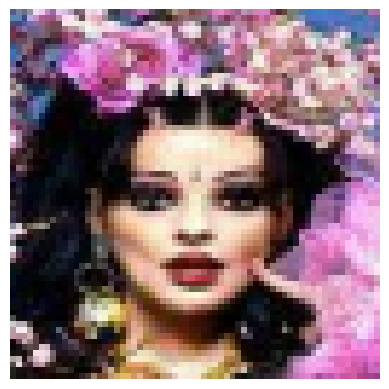

In [ ]:
for x in dataset:
    plt.axis("off")
    plt.imshow((x.numpy() * 255).astype("int32")[0])
    break

In [ ]:
discriminator = keras.Sequential(
    [
        keras.Input(shape=(64, 64, 3)),
        layers.Conv2D(64, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),  # Change 'negative_slope' to 'alpha'
        layers.Conv2D(128, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),  # Change 'negative_slope' to 'alpha'
        layers.Conv2D(128, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),  # Change 'negative_slope' to 'alpha'
        layers.Flatten(),
        layers.Dropout(0.2),
        layers.Dense(1, activation="sigmoid"),
    ],
    name="discriminator",
)
discriminator.summary()

Model: "discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 32, 32, 64)        3136      
                                                                 
 leaky_re_lu_6 (LeakyReLU)   (None, 32, 32, 64)        0         
                                                                 
 conv2d_6 (Conv2D)           (None, 16, 16, 128)       131200    
                                                                 
 leaky_re_lu_7 (LeakyReLU)   (None, 16, 16, 128)       0         
                                                                 
 conv2d_7 (Conv2D)           (None, 8, 8, 128)         262272    
                                                                 
 leaky_re_lu_8 (LeakyReLU)   (None, 8, 8, 128)         0         
                                                                 
 flatten_1 (Flatten)         (None, 8192)            

In [ ]:
latent_dim = 128

generator = keras.Sequential(
    [
        keras.Input(shape=(latent_dim,)),
        layers.Dense(8 * 8 * 128),
        layers.Reshape((8, 8, 128)),
        layers.Conv2DTranspose(128, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2DTranspose(256, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2DTranspose(512, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(3, kernel_size=5, padding="same", activation="sigmoid"),
    ],
    name="generator",
)
generator.summary()

Model: "generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 8192)              1056768   
                                                                 
 reshape_2 (Reshape)         (None, 8, 8, 128)         0         
                                                                 
 conv2d_transpose_4 (Conv2D  (None, 16, 16, 128)       262272    
 Transpose)                                                      
                                                                 
 leaky_re_lu_9 (LeakyReLU)   (None, 16, 16, 128)       0         
                                                                 
 conv2d_transpose_5 (Conv2D  (None, 32, 32, 256)       524544    
 Transpose)                                                      
                                                                 
 leaky_re_lu_10 (LeakyReLU)  (None, 32, 32, 256)       0 

In [ ]:
class GAN(keras.Model):
    def __init__(self, discriminator, generator, latent_dim):
        super().__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim
        self.seed = 1337

    def compile(self, d_optimizer, g_optimizer, loss_fn):
        super().compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn
        self.d_loss_metric = keras.metrics.Mean(name="d_loss")
        self.g_loss_metric = keras.metrics.Mean(name="g_loss")

    @property
    def metrics(self):
        return [self.d_loss_metric, self.g_loss_metric]

    def train_step(self, real_images):
        # Sample random points in the latent space
        batch_size = tf.shape(real_images)[0]
        random_latent_vectors = tf.random.normal(
            shape=(batch_size, self.latent_dim), seed=self.seed
        )

        # Decode them to fake images
        generated_images = self.generator(random_latent_vectors)

        # Combine them with real images
        combined_images = tf.concat([generated_images, real_images], axis=0)

        # Assemble labels discriminating real from fake images
        labels = tf.concat(
            [tf.ones((batch_size, 1)), tf.zeros((batch_size, 1))], axis=0
        )
        # Add random noise to the labels - important trick!
        labels += 0.05 * tf.random.uniform(tf.shape(labels))

        # Train the discriminator
        with tf.GradientTape() as tape:
            predictions = self.discriminator(combined_images)
            d_loss = self.loss_fn(labels, predictions)
        grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
        self.d_optimizer.apply_gradients(
            zip(grads, self.discriminator.trainable_weights)
        )

        # Sample random points in the latent space
        random_latent_vectors = tf.random.normal(
            shape=(batch_size, self.latent_dim), seed=self.seed
        )

        # Assemble labels that say "all real images"
        misleading_labels = tf.zeros((batch_size, 1))

        # Train the generator (note that we should *not* update the weights
        # of the discriminator)!
        with tf.GradientTape() as tape:
            predictions = self.discriminator(self.generator(random_latent_vectors))
            g_loss = self.loss_fn(misleading_labels, predictions)
        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))

        # Update metrics
        self.d_loss_metric.update_state(d_loss)
        self.g_loss_metric.update_state(g_loss)
        return {
            "d_loss": self.d_loss_metric.result(),
            "g_loss": self.g_loss_metric.result(),
        }

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

class GANMonitor(keras.callbacks.Callback):
    def __init__(self, num_img=3, latent_dim=128):
        self.num_img = num_img
        self.latent_dim = latent_dim
        self.seed_generator = tf.random.Generator.from_seed(42)

    def on_epoch_end(self, epoch, logs=None):
        random_latent_vectors = self.seed_generator.normal(
            shape=(self.num_img, self.latent_dim)
        )
        generated_images = self.model.generator(random_latent_vectors)
        generated_images = (generated_images * 127.5 + 127.5).numpy().astype(np.uint8)

        plt.figure(figsize=(10, 10))
        for i in range(self.num_img):
            plt.subplot(1, self.num_img, i + 1)
            plt.imshow(generated_images[i])
            plt.axis('off')
        plt.suptitle(f"Generated images at epoch {epoch}")
        plt.show()

Epoch 1/50
6331/6332 [============================>.] - ETA: 0s - d_loss: 0.6690 - g_loss: 0.9946

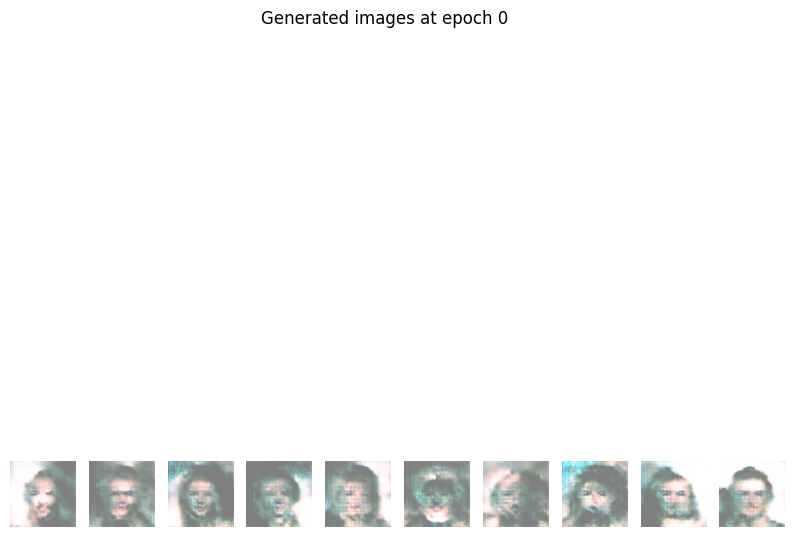

6332/6332 [==============================] - 163s 25ms/step - d_loss: 0.6690 - g_loss: 0.9947
Epoch 2/50
6330/6332 [============================>.] - ETA: 0s - d_loss: 0.6720 - g_loss: 0.9754

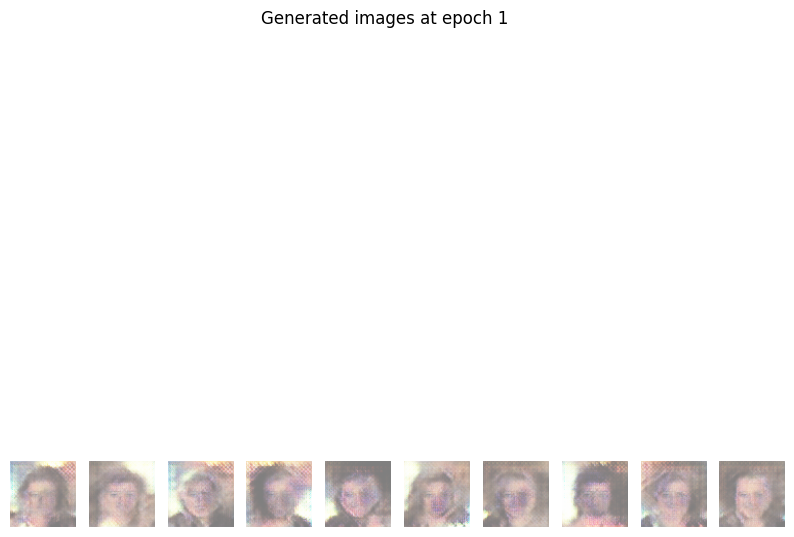

6332/6332 [==============================] - 160s 25ms/step - d_loss: 0.6720 - g_loss: 0.9754
Epoch 3/50
6330/6332 [============================>.] - ETA: 0s - d_loss: 0.6476 - g_loss: 1.0202

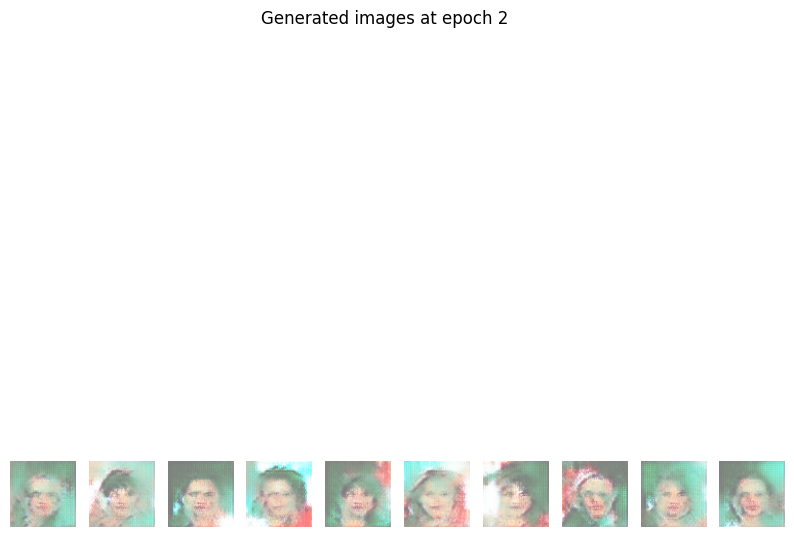

6332/6332 [==============================] - 160s 25ms/step - d_loss: 0.6476 - g_loss: 1.0202
Epoch 4/50
6332/6332 [==============================] - ETA: 0s - d_loss: 0.6573 - g_loss: 0.9707

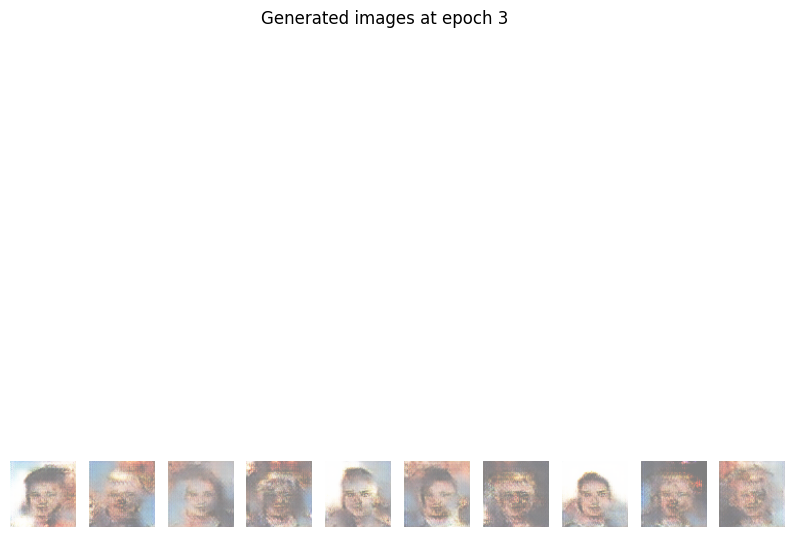

6332/6332 [==============================] - 160s 25ms/step - d_loss: 0.6573 - g_loss: 0.9707
Epoch 5/50
6330/6332 [============================>.] - ETA: 0s - d_loss: 0.6662 - g_loss: 0.9463

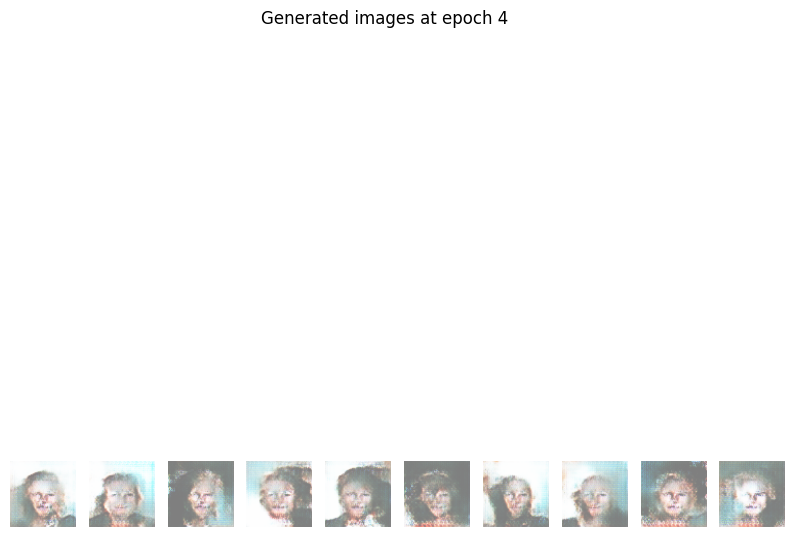

6332/6332 [==============================] - 160s 25ms/step - d_loss: 0.6662 - g_loss: 0.9463
Epoch 6/50
6331/6332 [============================>.] - ETA: 0s - d_loss: 0.6720 - g_loss: 0.9256

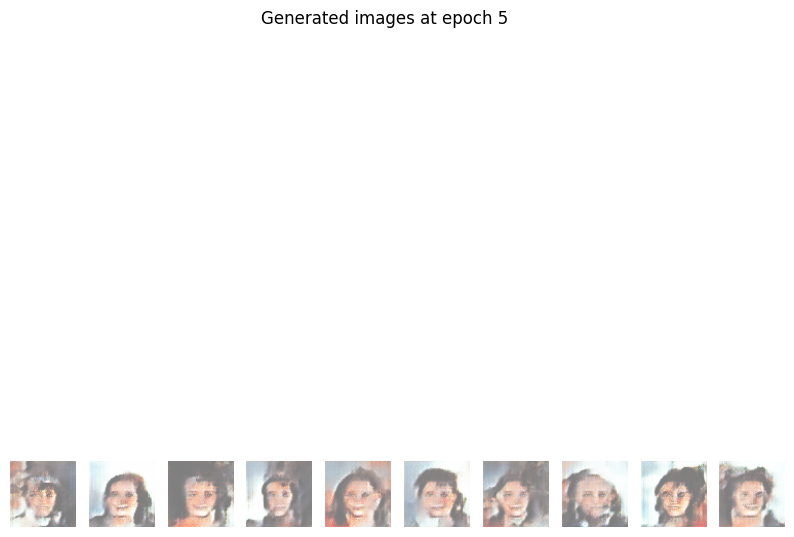

6332/6332 [==============================] - 162s 26ms/step - d_loss: 0.6720 - g_loss: 0.9257
Epoch 7/50
6330/6332 [============================>.] - ETA: 0s - d_loss: 0.6754 - g_loss: 0.9236

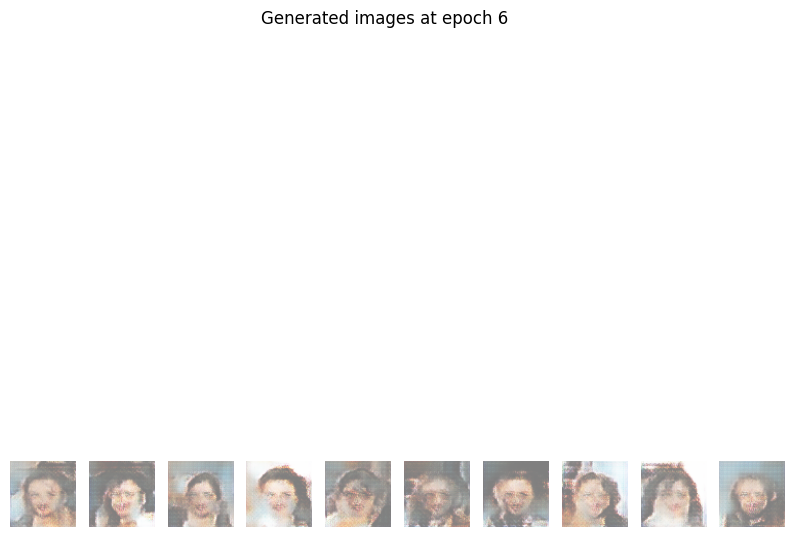

6332/6332 [==============================] - 169s 27ms/step - d_loss: 0.6754 - g_loss: 0.9236
Epoch 8/50
6330/6332 [============================>.] - ETA: 0s - d_loss: 0.6804 - g_loss: 0.8993

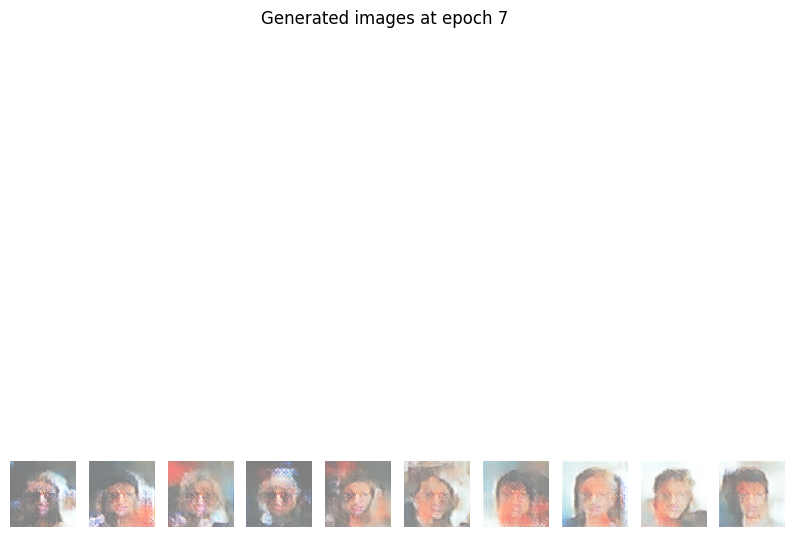

6332/6332 [==============================] - 168s 27ms/step - d_loss: 0.6804 - g_loss: 0.8993
Epoch 9/50
6331/6332 [============================>.] - ETA: 0s - d_loss: 0.6802 - g_loss: 0.8937

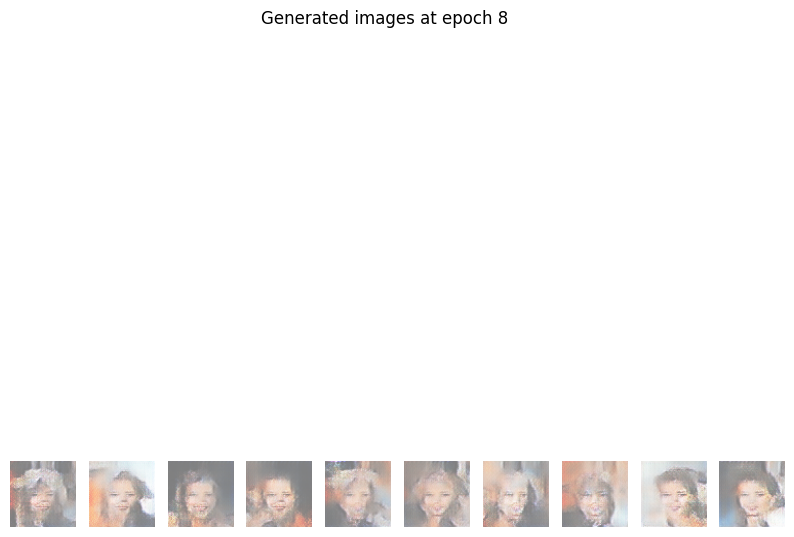

6332/6332 [==============================] - 169s 27ms/step - d_loss: 0.6802 - g_loss: 0.8937
Epoch 10/50
6330/6332 [============================>.] - ETA: 0s - d_loss: 0.6795 - g_loss: 0.8962

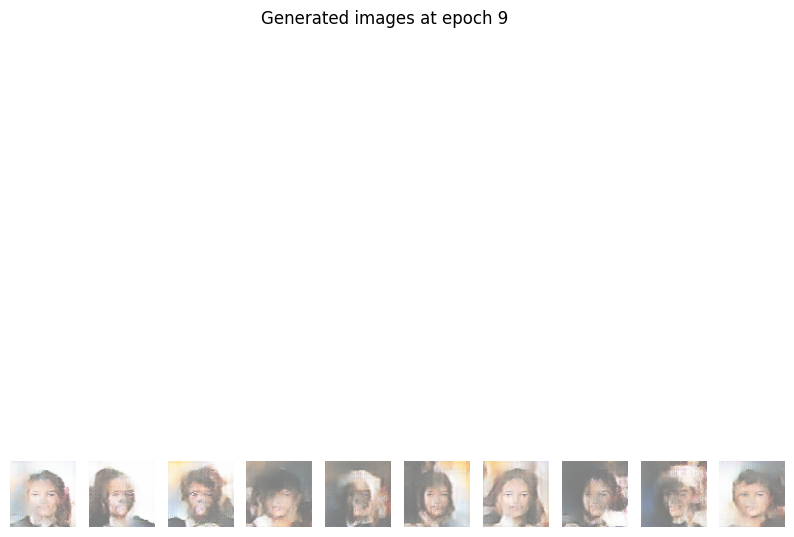

6332/6332 [==============================] - 168s 27ms/step - d_loss: 0.6796 - g_loss: 0.8961
Epoch 11/50
6332/6332 [==============================] - ETA: 0s - d_loss: 0.6802 - g_loss: 0.8701

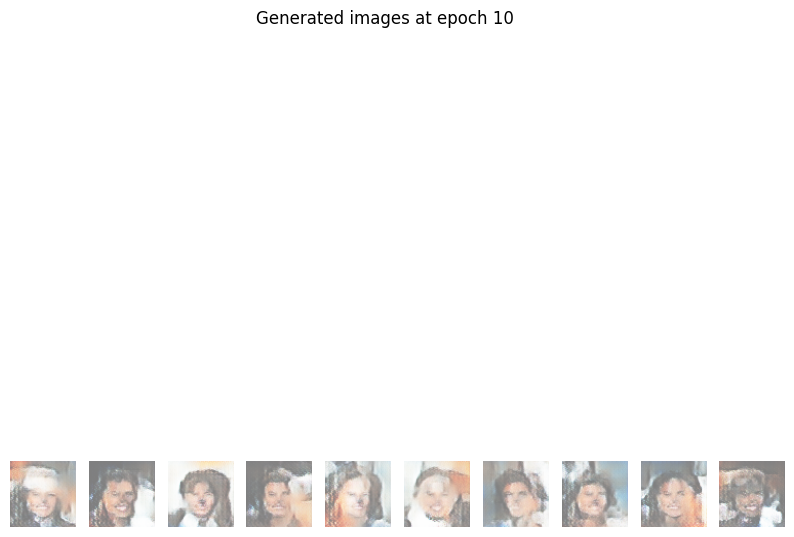

6332/6332 [==============================] - 166s 26ms/step - d_loss: 0.6802 - g_loss: 0.8701
Epoch 12/50
6330/6332 [============================>.] - ETA: 0s - d_loss: 0.6780 - g_loss: 0.8845

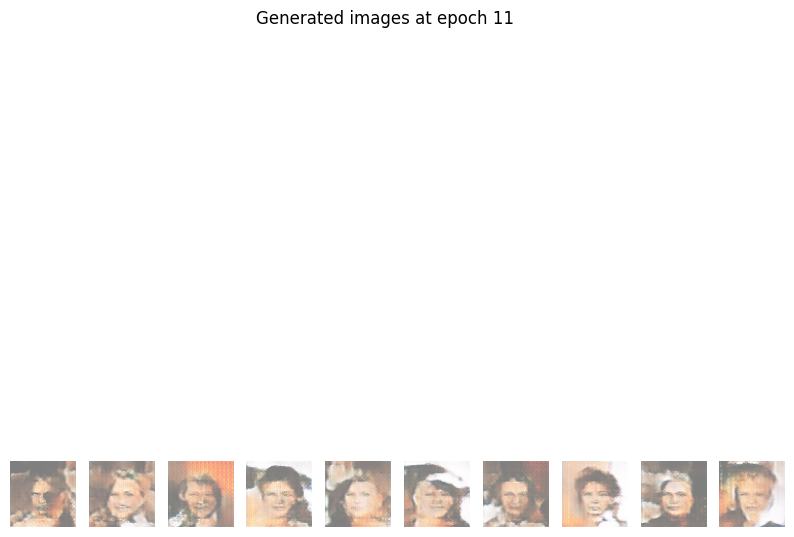

6332/6332 [==============================] - 161s 25ms/step - d_loss: 0.6780 - g_loss: 0.8845
Epoch 13/50
6331/6332 [============================>.] - ETA: 0s - d_loss: 0.6728 - g_loss: 0.9042

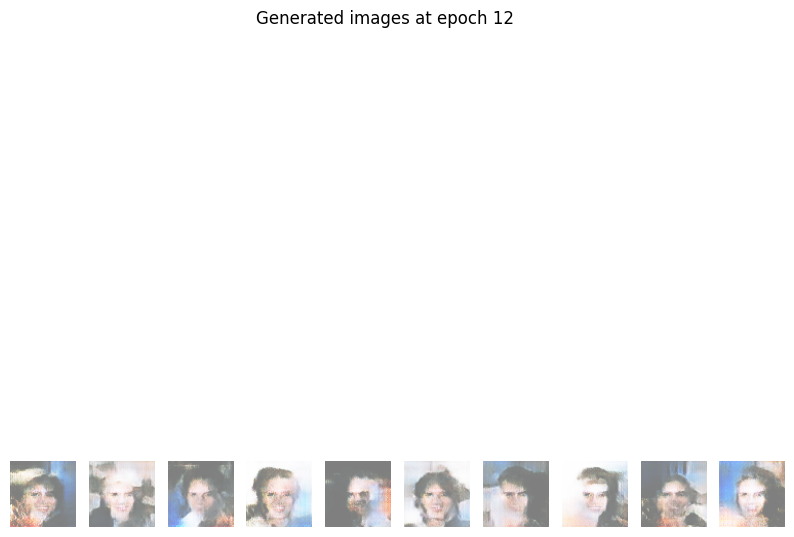

6332/6332 [==============================] - 167s 26ms/step - d_loss: 0.6728 - g_loss: 0.9042
Epoch 14/50
6330/6332 [============================>.] - ETA: 0s - d_loss: 0.6624 - g_loss: 0.9260

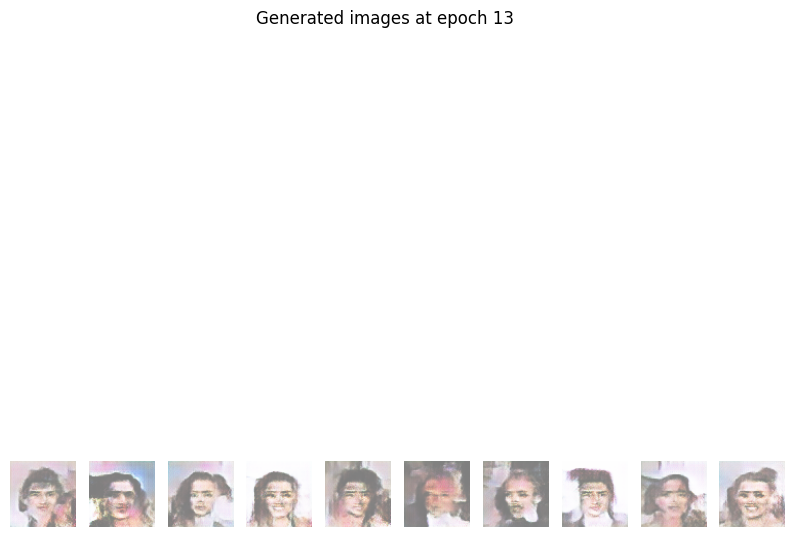

6332/6332 [==============================] - 169s 27ms/step - d_loss: 0.6624 - g_loss: 0.9260
Epoch 15/50
6331/6332 [============================>.] - ETA: 0s - d_loss: 0.6605 - g_loss: 0.9279

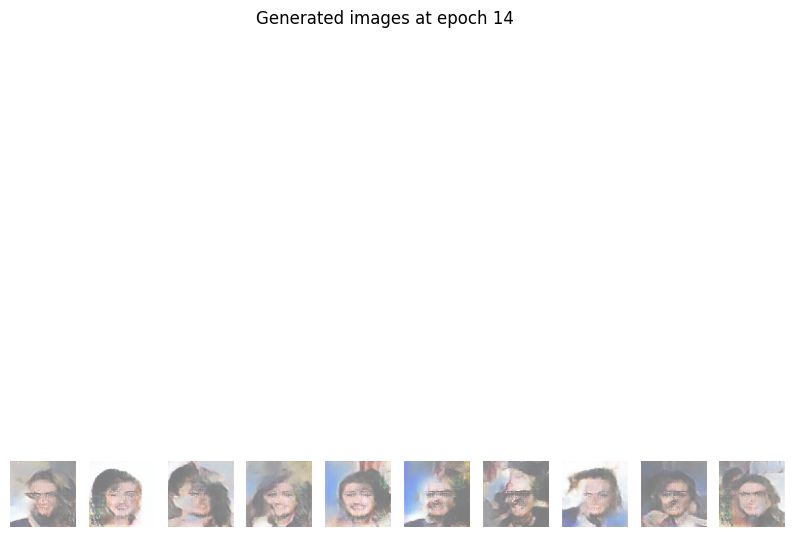

6332/6332 [==============================] - 169s 27ms/step - d_loss: 0.6605 - g_loss: 0.9279
Epoch 16/50
6330/6332 [============================>.] - ETA: 0s - d_loss: 0.6589 - g_loss: 0.9458

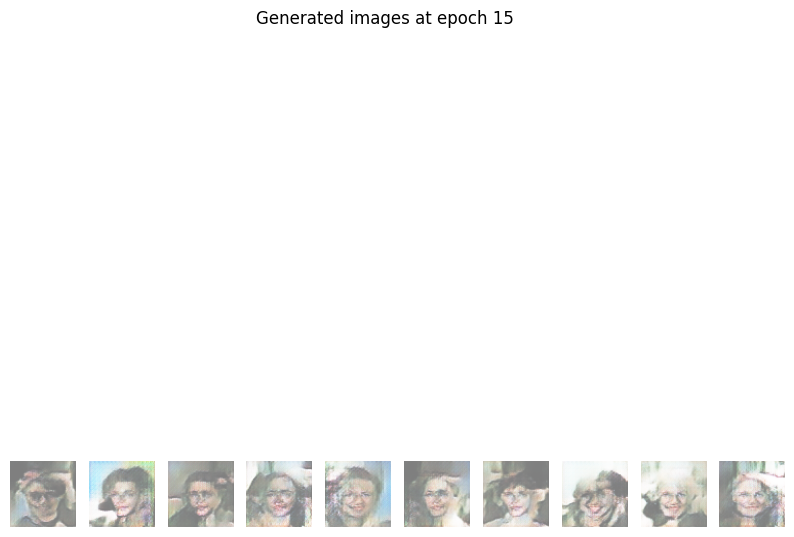

6332/6332 [==============================] - 169s 27ms/step - d_loss: 0.6589 - g_loss: 0.9458
Epoch 17/50
6330/6332 [============================>.] - ETA: 0s - d_loss: 0.6525 - g_loss: 0.9415

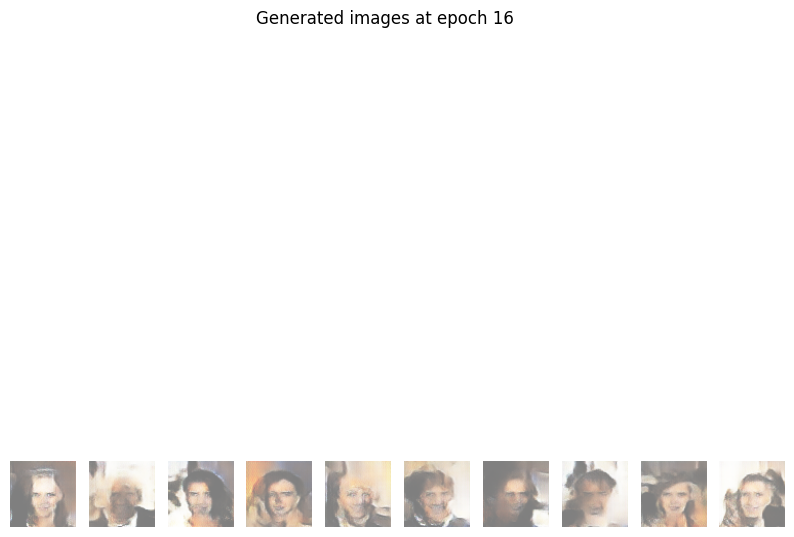

6332/6332 [==============================] - 169s 27ms/step - d_loss: 0.6525 - g_loss: 0.9415
Epoch 18/50
6331/6332 [============================>.] - ETA: 0s - d_loss: 0.6543 - g_loss: 0.9306

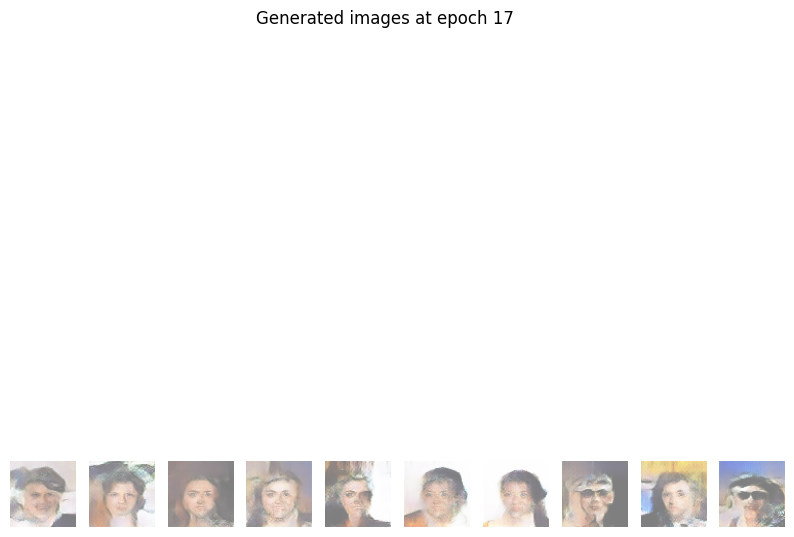

6332/6332 [==============================] - 169s 27ms/step - d_loss: 0.6544 - g_loss: 0.9306
Epoch 19/50
6331/6332 [============================>.] - ETA: 0s - d_loss: 0.6511 - g_loss: 0.9445

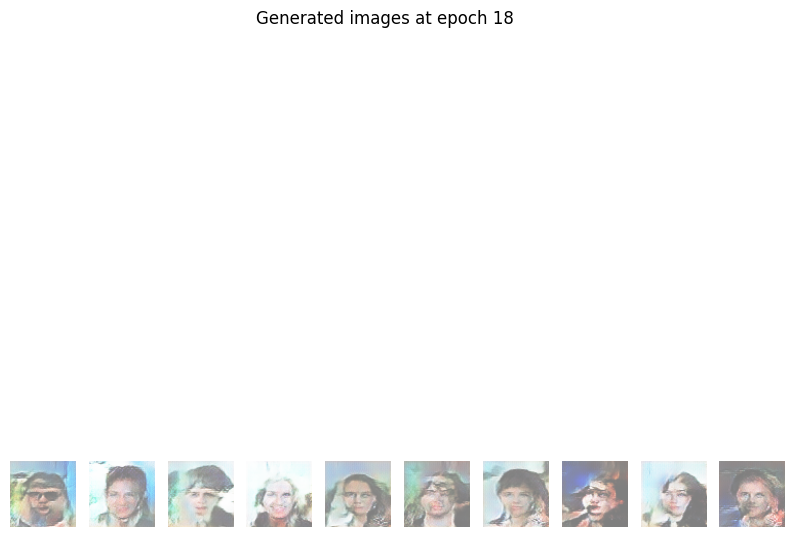

6332/6332 [==============================] - 169s 27ms/step - d_loss: 0.6511 - g_loss: 0.9445
Epoch 20/50
6330/6332 [============================>.] - ETA: 0s - d_loss: 0.6566 - g_loss: 0.9524

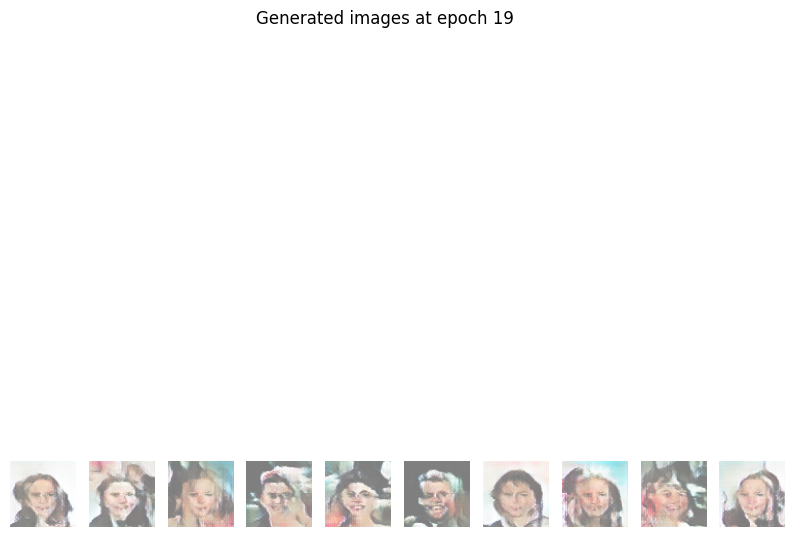

6332/6332 [==============================] - 169s 27ms/step - d_loss: 0.6565 - g_loss: 0.9525
Epoch 21/50
6330/6332 [============================>.] - ETA: 0s - d_loss: 0.6479 - g_loss: 0.9354

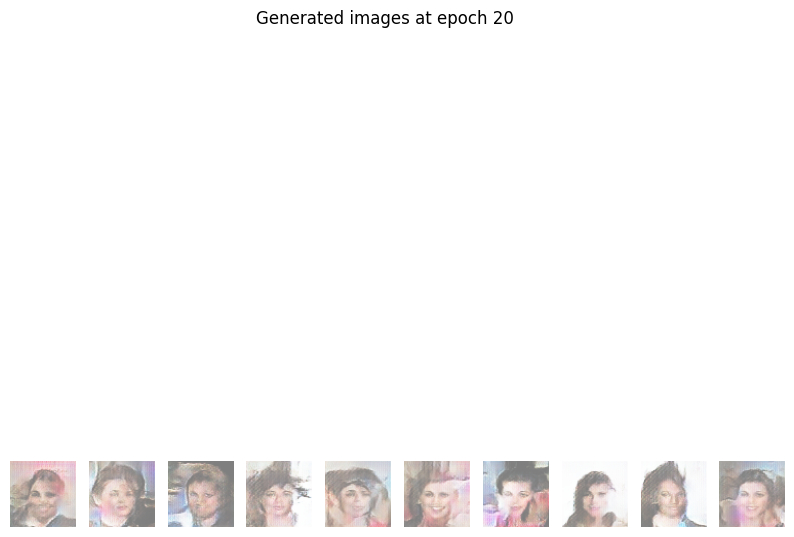

6332/6332 [==============================] - 169s 27ms/step - d_loss: 0.6479 - g_loss: 0.9354
Epoch 22/50
6331/6332 [============================>.] - ETA: 0s - d_loss: 0.6534 - g_loss: 0.9442

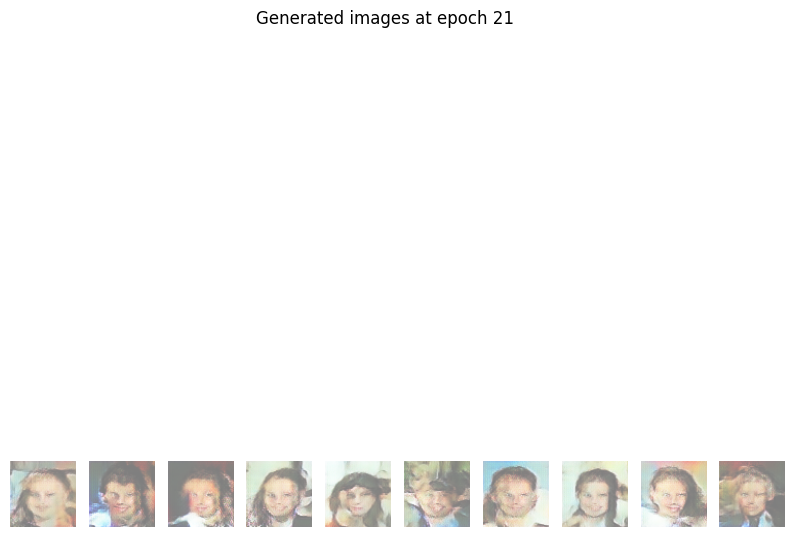

6332/6332 [==============================] - 169s 27ms/step - d_loss: 0.6534 - g_loss: 0.9442
Epoch 23/50
6330/6332 [============================>.] - ETA: 0s - d_loss: 0.6480 - g_loss: 0.9404

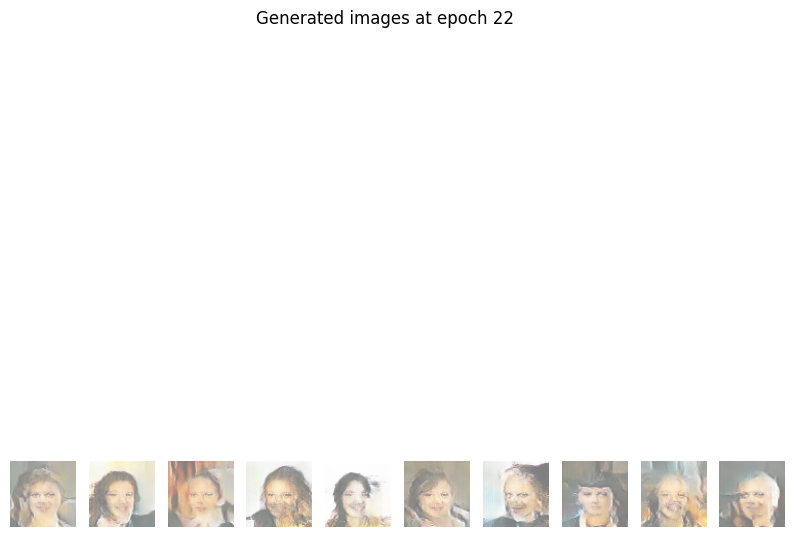

6332/6332 [==============================] - 169s 27ms/step - d_loss: 0.6480 - g_loss: 0.9405
Epoch 24/50
6330/6332 [============================>.] - ETA: 0s - d_loss: 0.6487 - g_loss: 0.9386

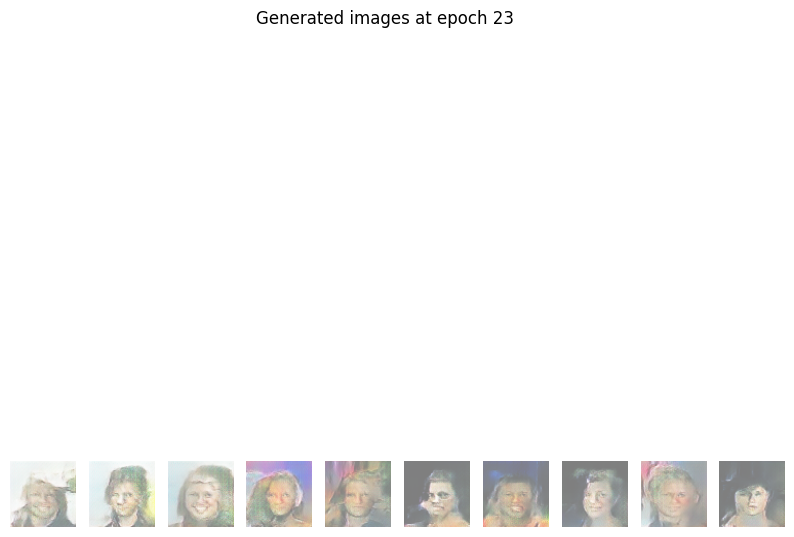

6332/6332 [==============================] - 170s 27ms/step - d_loss: 0.6488 - g_loss: 0.9386
Epoch 25/50
6330/6332 [============================>.] - ETA: 0s - d_loss: 0.6507 - g_loss: 0.9411

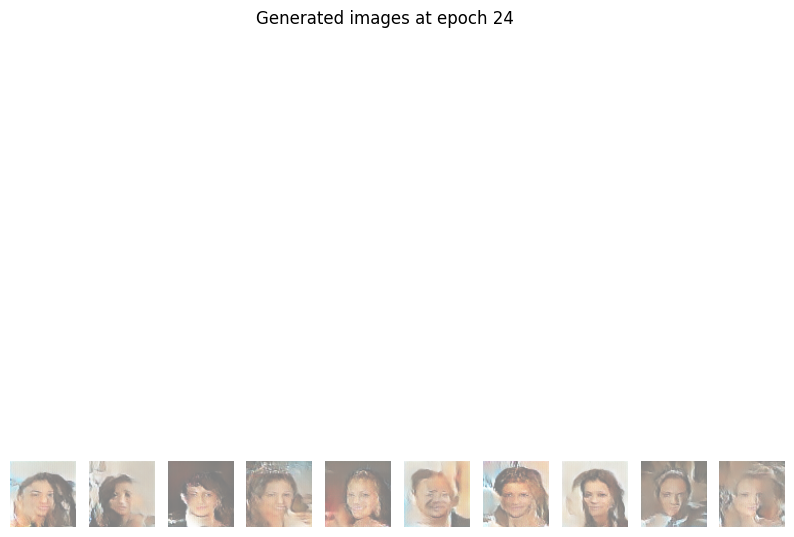

6332/6332 [==============================] - 171s 27ms/step - d_loss: 0.6507 - g_loss: 0.9411
Epoch 26/50
6331/6332 [============================>.] - ETA: 0s - d_loss: 0.6519 - g_loss: 0.9400

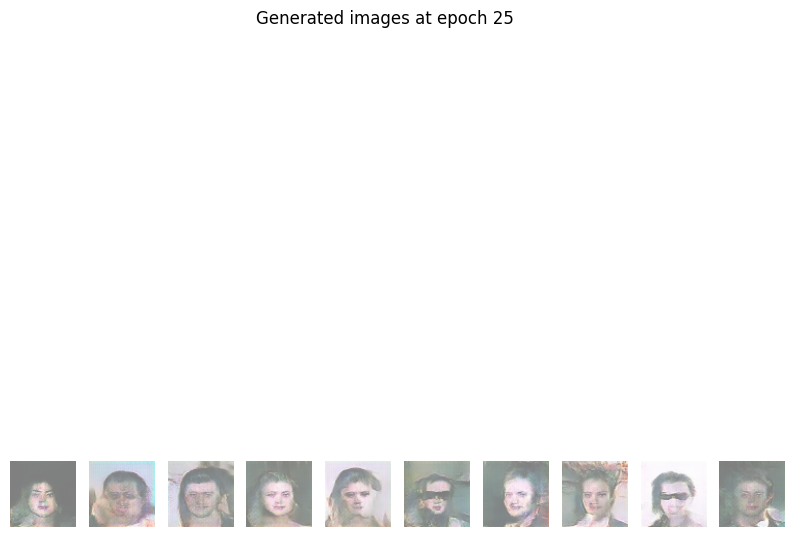

6332/6332 [==============================] - 170s 27ms/step - d_loss: 0.6519 - g_loss: 0.9400
Epoch 27/50
6331/6332 [============================>.] - ETA: 0s - d_loss: 0.6533 - g_loss: 0.9361

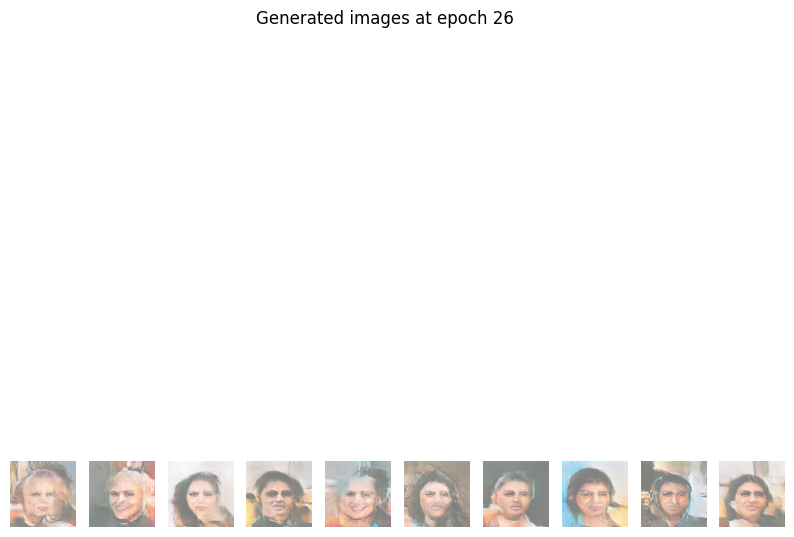

6332/6332 [==============================] - 170s 27ms/step - d_loss: 0.6533 - g_loss: 0.9361
Epoch 28/50
6330/6332 [============================>.] - ETA: 0s - d_loss: 0.6515 - g_loss: 0.9388

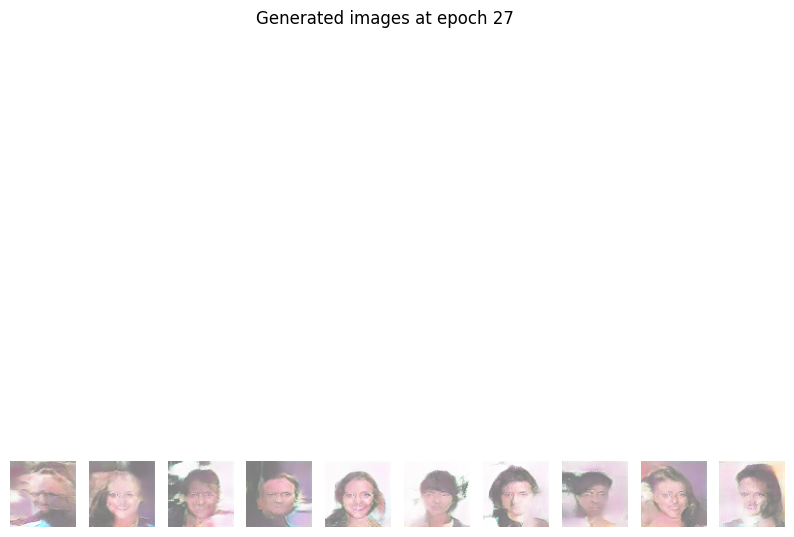

6332/6332 [==============================] - 170s 27ms/step - d_loss: 0.6515 - g_loss: 0.9388
Epoch 29/50
6330/6332 [============================>.] - ETA: 0s - d_loss: 0.6495 - g_loss: 0.9335

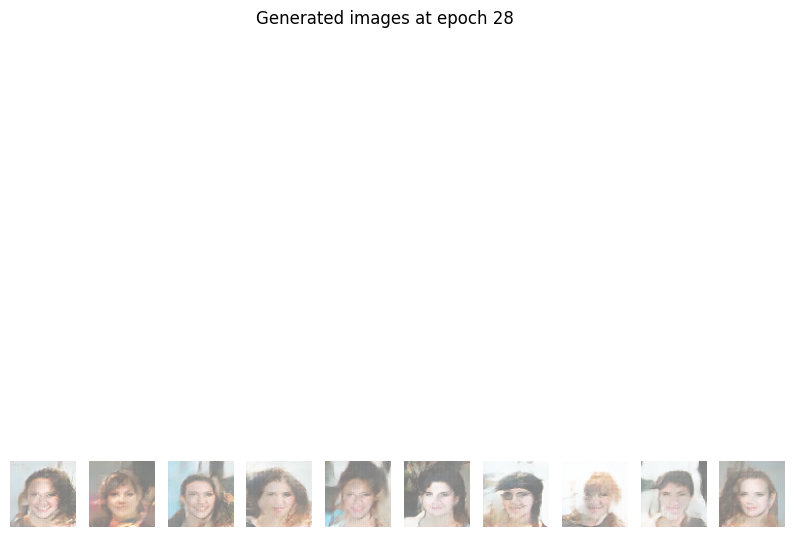

6332/6332 [==============================] - 169s 27ms/step - d_loss: 0.6495 - g_loss: 0.9334
Epoch 30/50
6331/6332 [============================>.] - ETA: 0s - d_loss: 0.6527 - g_loss: 0.9326

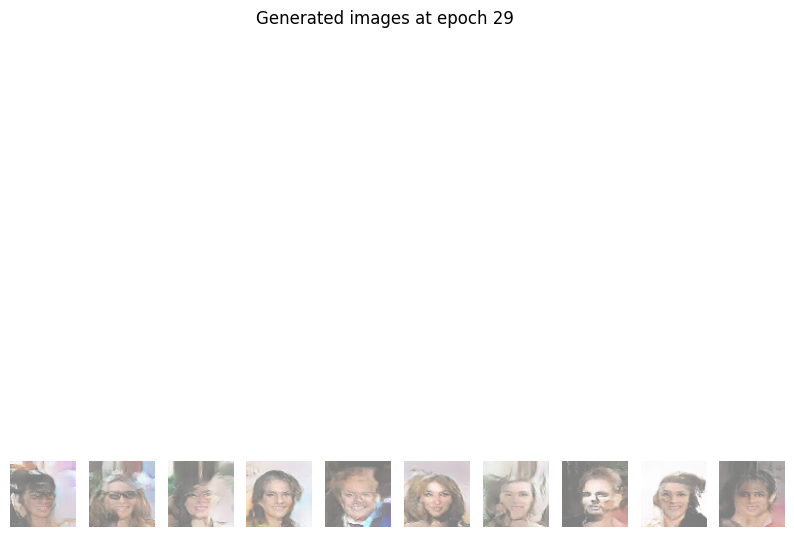

6332/6332 [==============================] - 170s 27ms/step - d_loss: 0.6527 - g_loss: 0.9325
Epoch 31/50
6331/6332 [============================>.] - ETA: 0s - d_loss: 0.6490 - g_loss: 0.9260

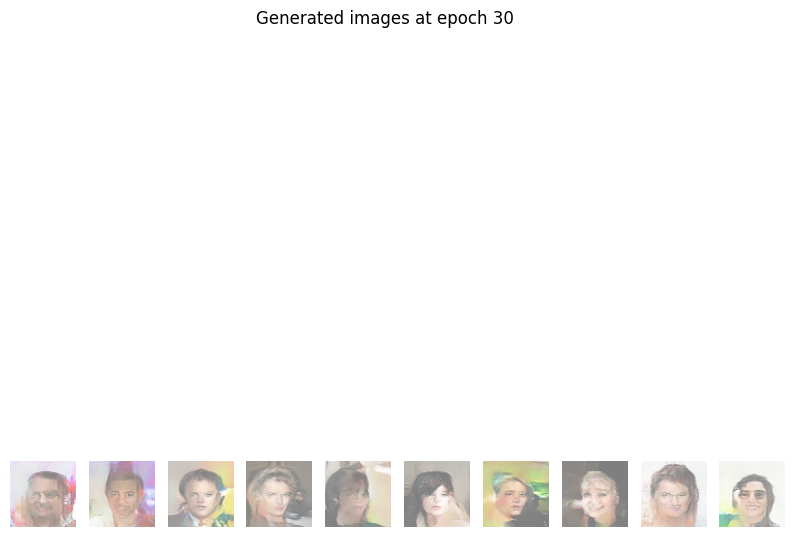

6332/6332 [==============================] - 169s 27ms/step - d_loss: 0.6490 - g_loss: 0.9260
Epoch 32/50
6330/6332 [============================>.] - ETA: 0s - d_loss: 0.6482 - g_loss: 0.9408

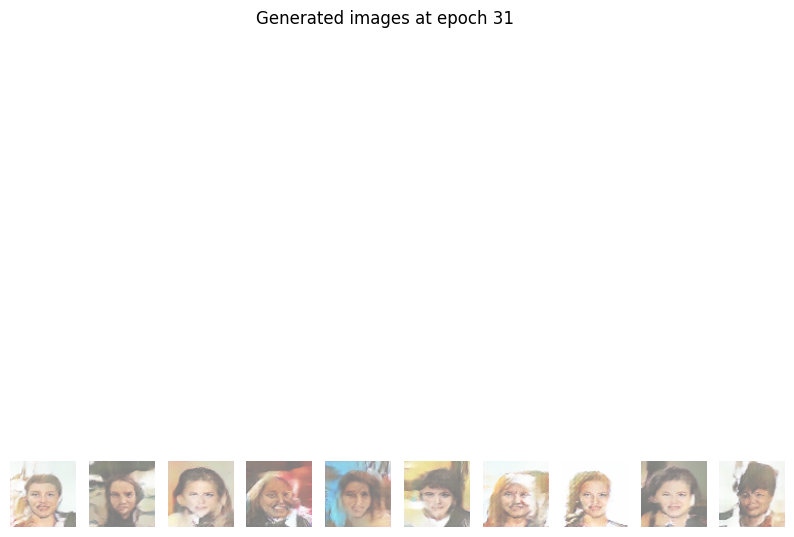

6332/6332 [==============================] - 169s 27ms/step - d_loss: 0.6482 - g_loss: 0.9408
Epoch 33/50
6330/6332 [============================>.] - ETA: 0s - d_loss: 0.6467 - g_loss: 0.9378

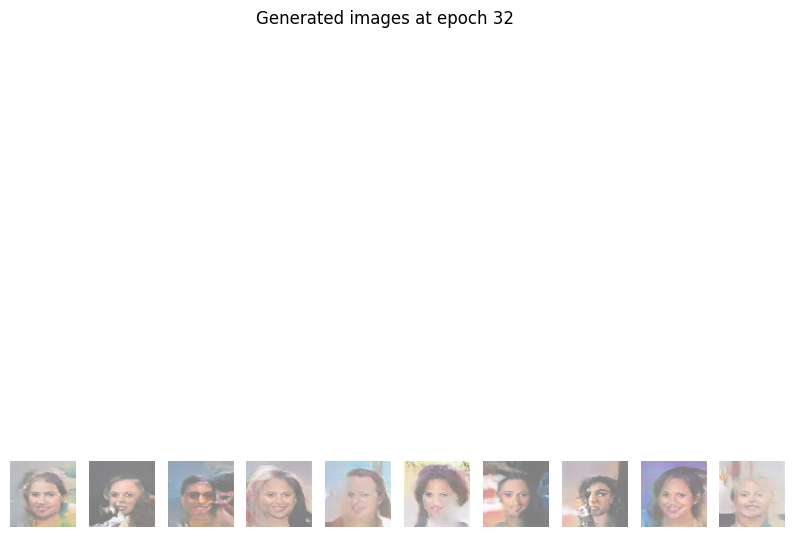

6332/6332 [==============================] - 169s 27ms/step - d_loss: 0.6467 - g_loss: 0.9377
Epoch 34/50
6331/6332 [============================>.] - ETA: 0s - d_loss: 0.6458 - g_loss: 0.9460

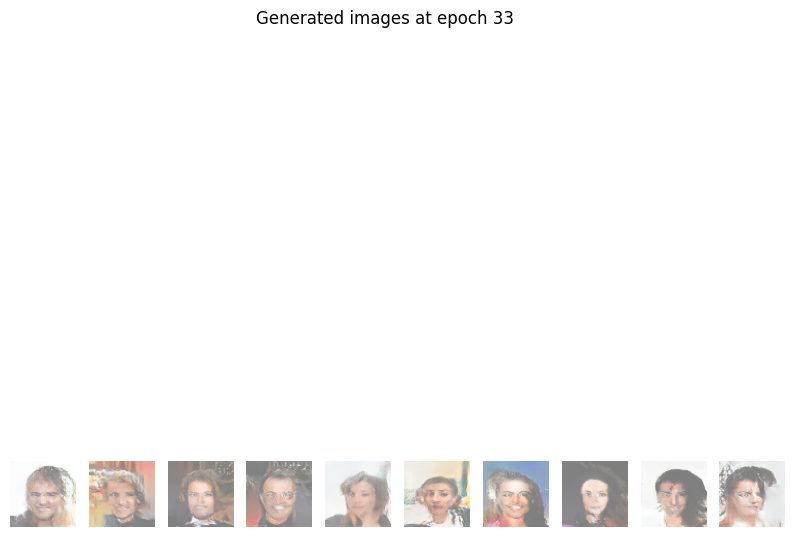

6332/6332 [==============================] - 170s 27ms/step - d_loss: 0.6458 - g_loss: 0.9460
Epoch 35/50
6331/6332 [============================>.] - ETA: 0s - d_loss: 0.6436 - g_loss: 0.9524

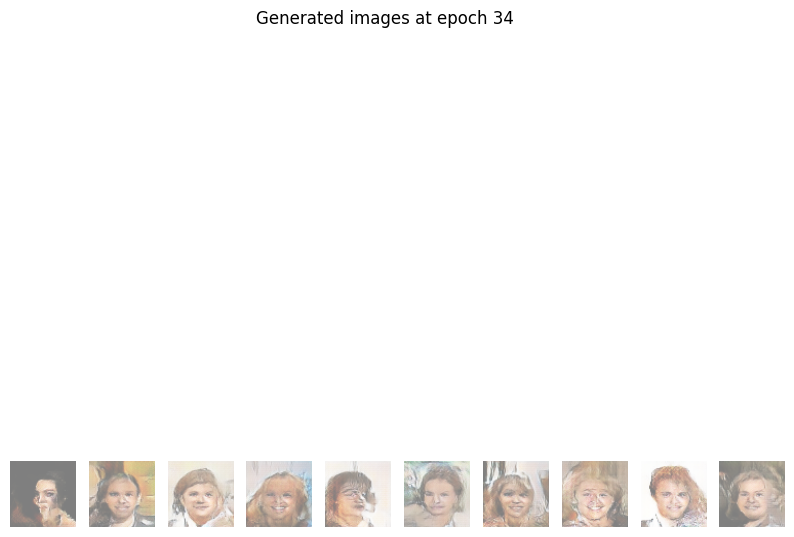

6332/6332 [==============================] - 169s 27ms/step - d_loss: 0.6435 - g_loss: 0.9524
Epoch 36/50
6330/6332 [============================>.] - ETA: 0s - d_loss: 0.6405 - g_loss: 0.9513

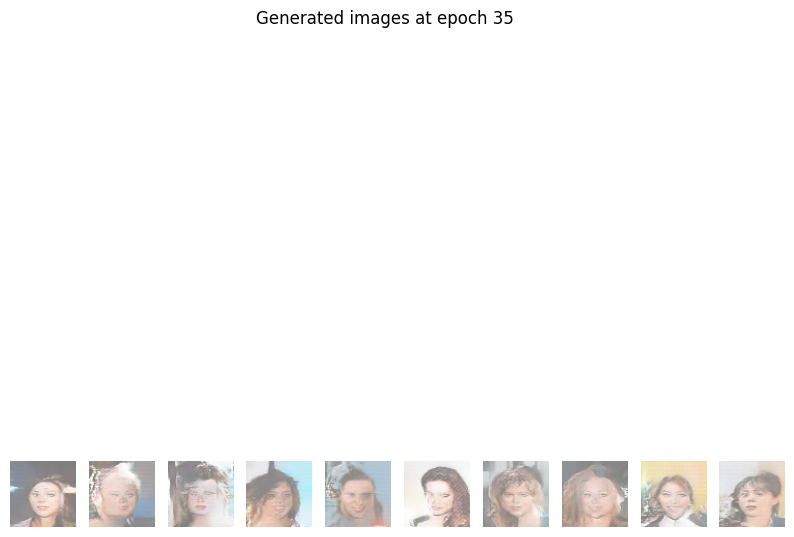

6332/6332 [==============================] - 169s 27ms/step - d_loss: 0.6405 - g_loss: 0.9514
Epoch 37/50
6331/6332 [============================>.] - ETA: 0s - d_loss: 0.6387 - g_loss: 0.9553

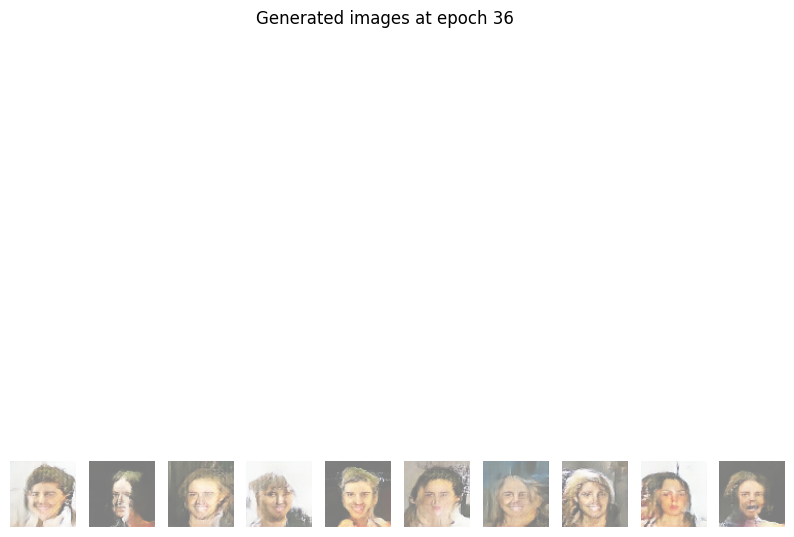

6332/6332 [==============================] - 170s 27ms/step - d_loss: 0.6387 - g_loss: 0.9553
Epoch 38/50
6331/6332 [============================>.] - ETA: 0s - d_loss: 0.6376 - g_loss: 0.9649

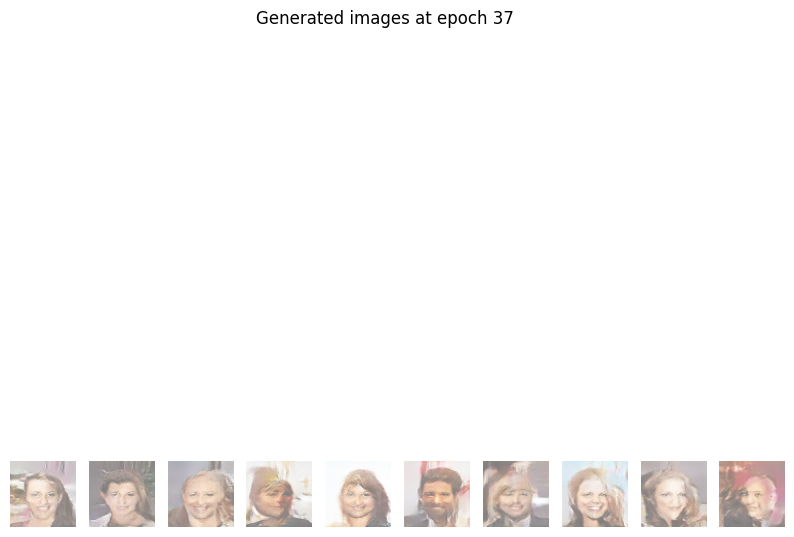

6332/6332 [==============================] - 170s 27ms/step - d_loss: 0.6376 - g_loss: 0.9649
Epoch 39/50
6331/6332 [============================>.] - ETA: 0s - d_loss: 0.6338 - g_loss: 0.9699

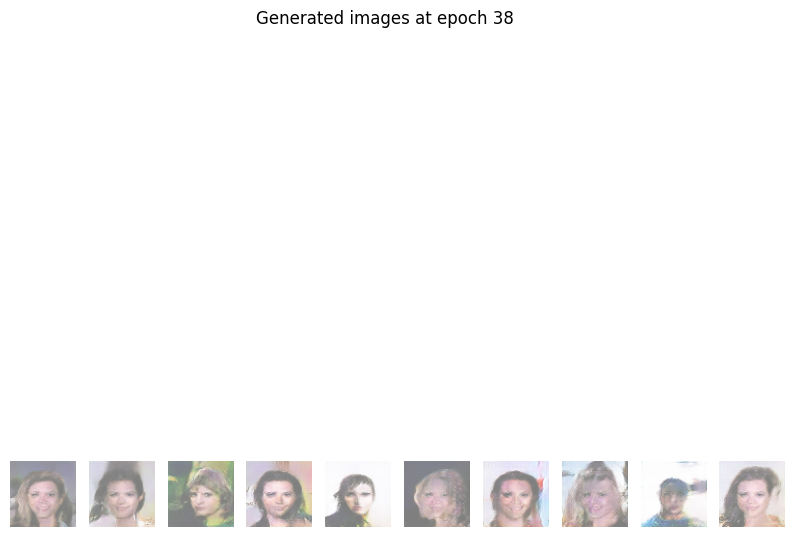

6332/6332 [==============================] - 170s 27ms/step - d_loss: 0.6338 - g_loss: 0.9699
Epoch 40/50
6331/6332 [============================>.] - ETA: 0s - d_loss: 0.6310 - g_loss: 0.9785

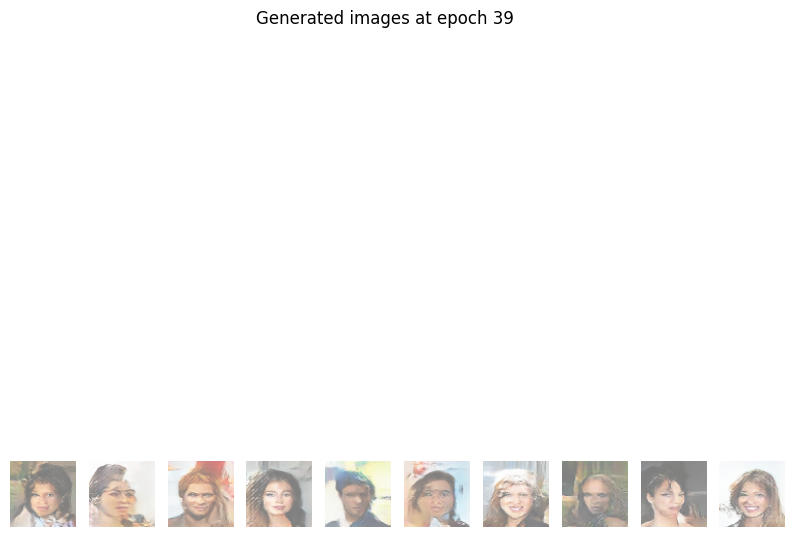

6332/6332 [==============================] - 169s 27ms/step - d_loss: 0.6310 - g_loss: 0.9785
Epoch 41/50
6331/6332 [============================>.] - ETA: 0s - d_loss: 0.6278 - g_loss: 0.9749

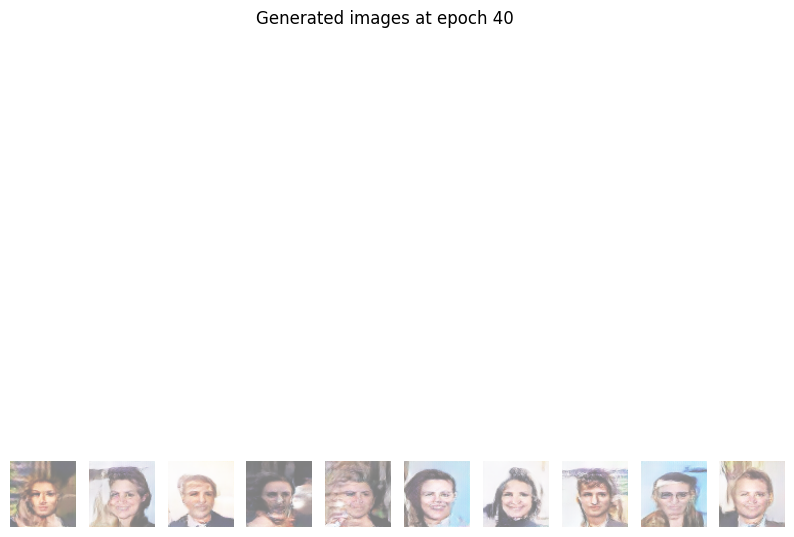

6332/6332 [==============================] - 169s 27ms/step - d_loss: 0.6278 - g_loss: 0.9750
Epoch 42/50
6331/6332 [============================>.] - ETA: 0s - d_loss: 0.6283 - g_loss: 0.9972

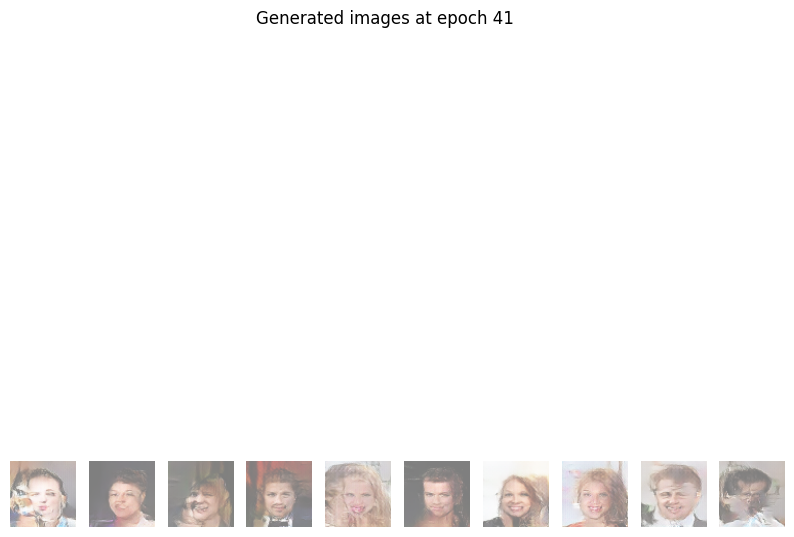

6332/6332 [==============================] - 169s 27ms/step - d_loss: 0.6283 - g_loss: 0.9972
Epoch 43/50
6330/6332 [============================>.] - ETA: 0s - d_loss: 0.6251 - g_loss: 0.9881

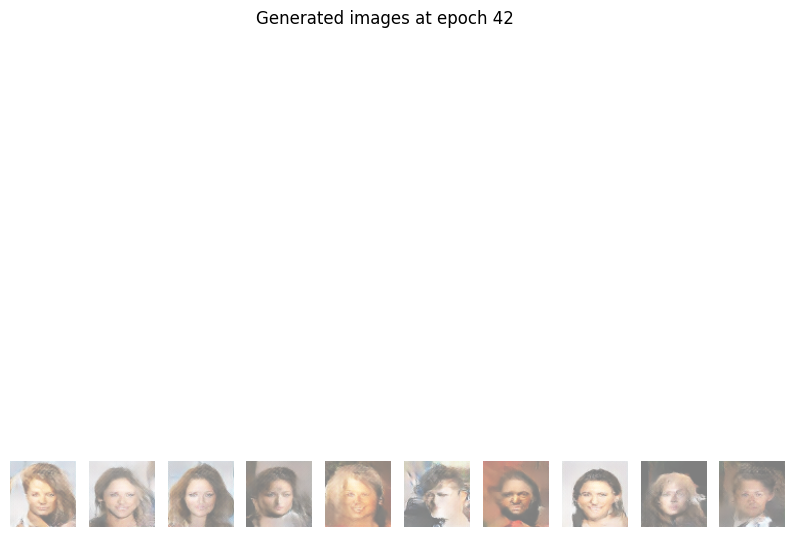

6332/6332 [==============================] - 169s 27ms/step - d_loss: 0.6252 - g_loss: 0.9881
Epoch 44/50
6330/6332 [============================>.] - ETA: 0s - d_loss: 0.6223 - g_loss: 1.0023

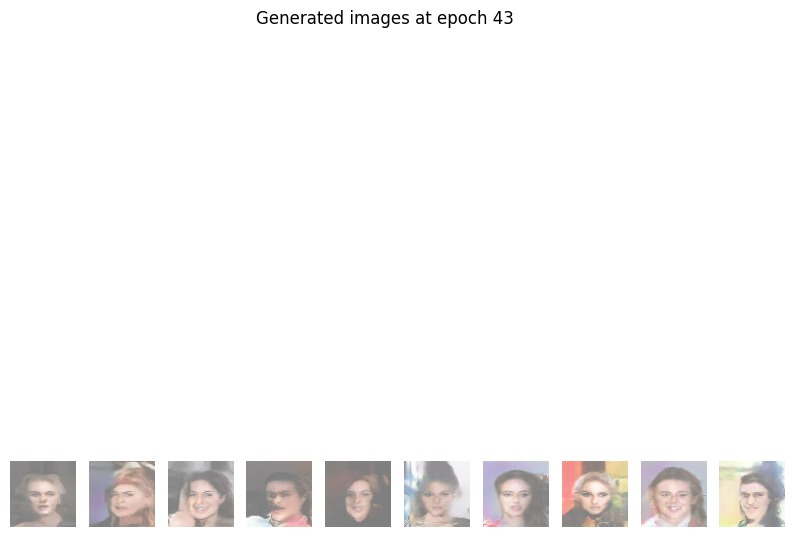

6332/6332 [==============================] - 170s 27ms/step - d_loss: 0.6223 - g_loss: 1.0022
Epoch 45/50
6330/6332 [============================>.] - ETA: 0s - d_loss: 0.6220 - g_loss: 1.0025

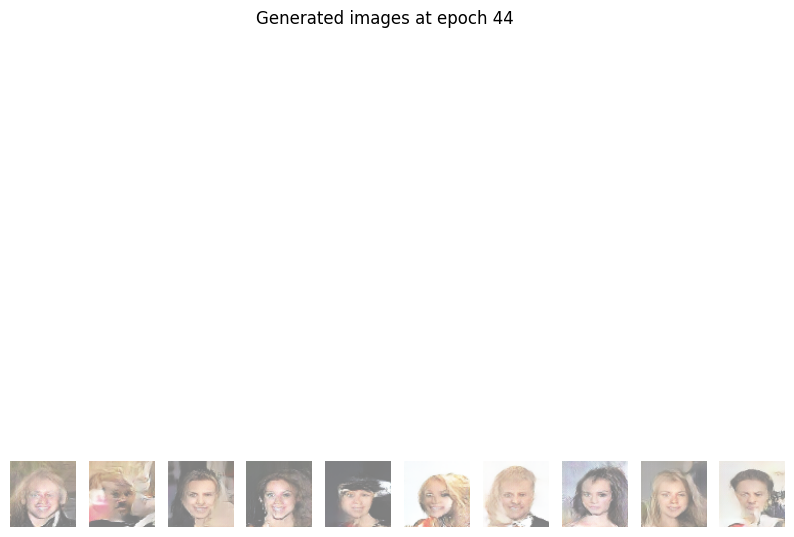

6332/6332 [==============================] - 169s 27ms/step - d_loss: 0.6220 - g_loss: 1.0026
Epoch 46/50
6330/6332 [============================>.] - ETA: 0s - d_loss: 0.6195 - g_loss: 1.0136

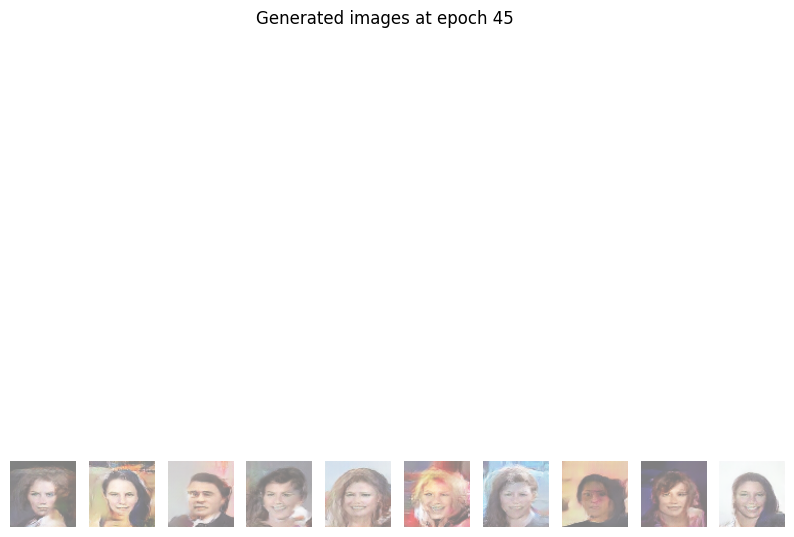

6332/6332 [==============================] - 169s 27ms/step - d_loss: 0.6195 - g_loss: 1.0136
Epoch 47/50
6330/6332 [============================>.] - ETA: 0s - d_loss: 0.6190 - g_loss: 1.0168

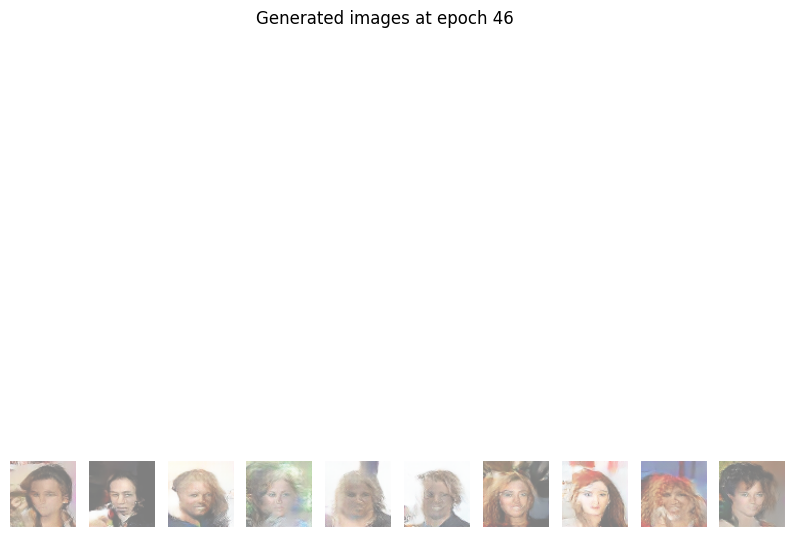

6332/6332 [==============================] - 169s 27ms/step - d_loss: 0.6190 - g_loss: 1.0168
Epoch 48/50
6331/6332 [============================>.] - ETA: 0s - d_loss: 0.6132 - g_loss: 1.0227

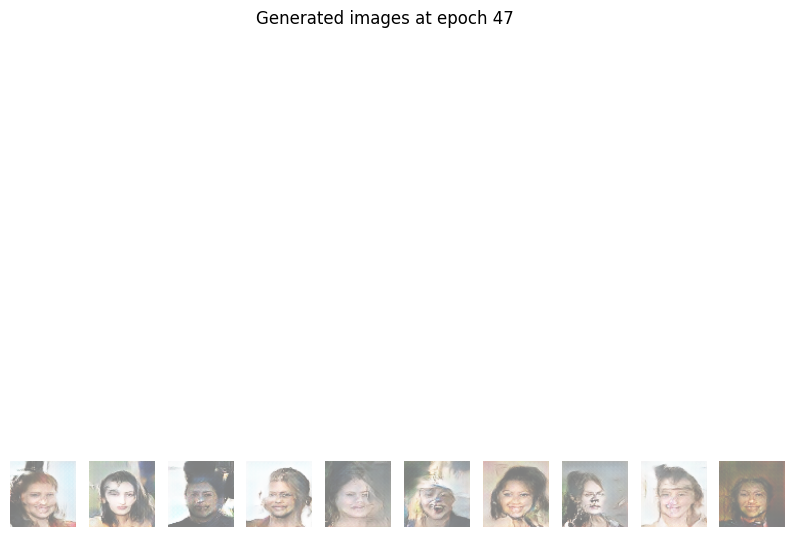

6332/6332 [==============================] - 164s 26ms/step - d_loss: 0.6132 - g_loss: 1.0228
Epoch 49/50
6330/6332 [============================>.] - ETA: 0s - d_loss: 0.6120 - g_loss: 1.0400

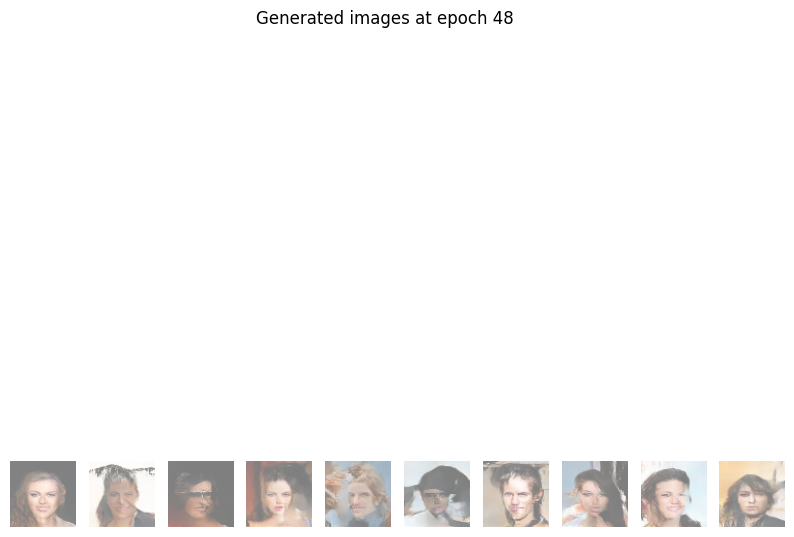

6332/6332 [==============================] - 162s 26ms/step - d_loss: 0.6120 - g_loss: 1.0401
Epoch 50/50
6330/6332 [============================>.] - ETA: 0s - d_loss: 0.6152 - g_loss: 1.0444

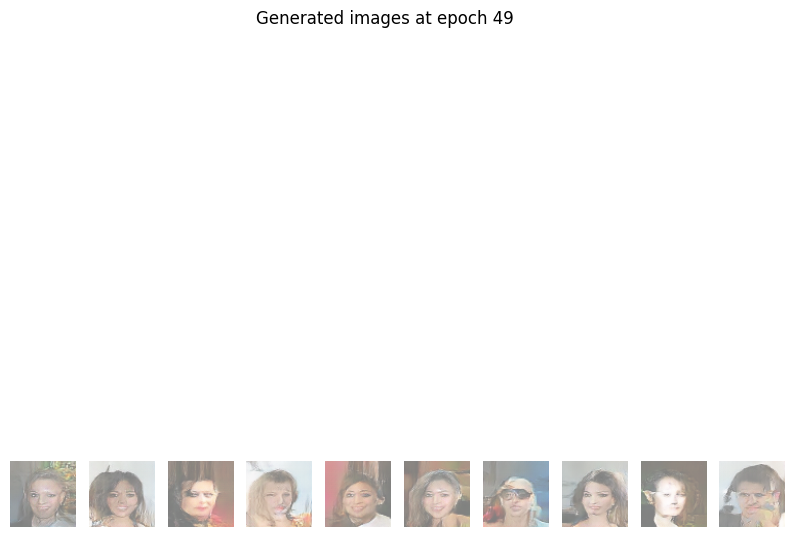

6332/6332 [==============================] - 162s 26ms/step - d_loss: 0.6152 - g_loss: 1.0444


In [ ]:
epochs = 50
gan = GAN(discriminator=discriminator, generator=generator, latent_dim=latent_dim)
gan.compile(
    d_optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    g_optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    loss_fn=keras.losses.BinaryCrossentropy(),
)

gan.fit(
    dataset, epochs=epochs, callbacks=[GANMonitor(num_img=10, latent_dim=latent_dim)]
)

In [ ]:
# Save weights of the GAN model
gan.save_weights('model_weights.h5')
# Save the GAN model as a TensorFlow SavedModel
tf.saved_model.save(gan, 'saved_model/')


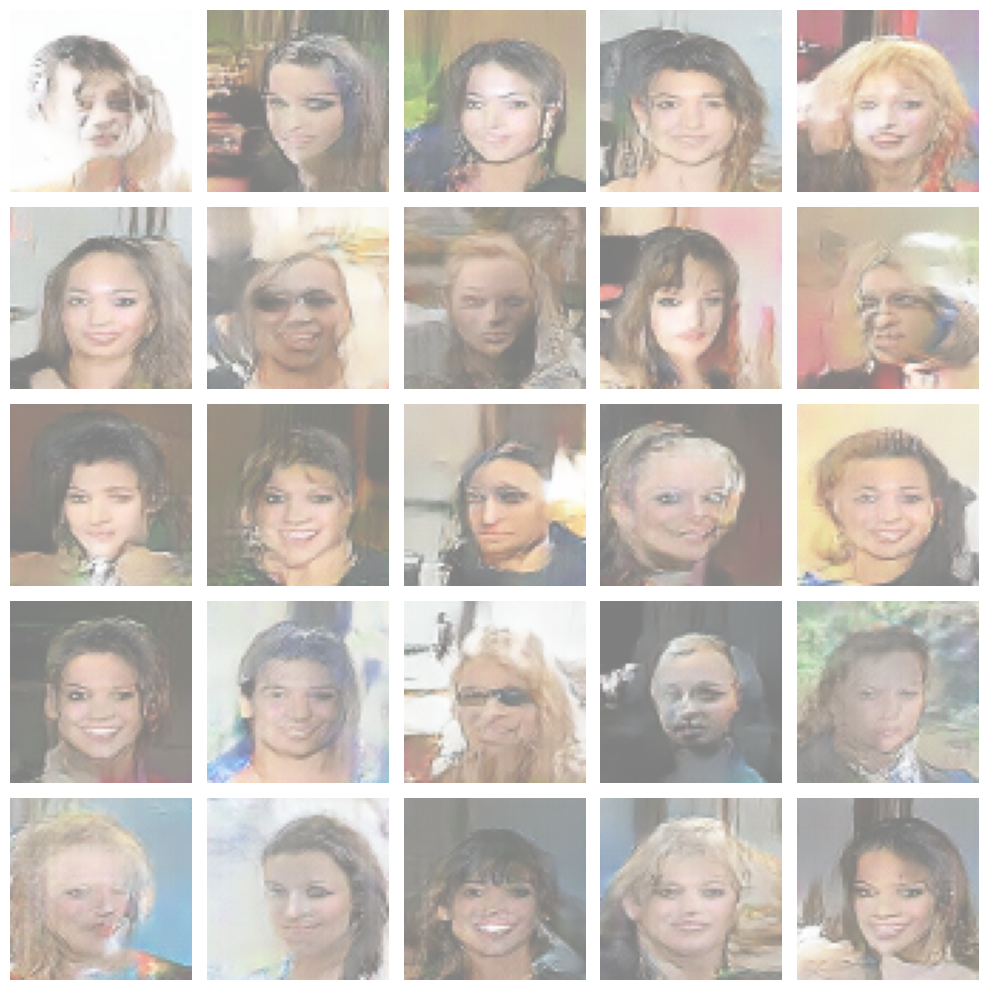

In [70]:
import matplotlib.pyplot as plt
num_images=25
random_latent_vectors = tf.random.normal(shape=(25, latent_dim))

generated_images = gan.generator(random_latent_vectors, training=False)

plt.figure(figsize=(10, 10))
for i in range(num_images):
    plt.subplot(5, 5, i + 1)
    plt.imshow(generated_images[i] * 0.5 + 0.5)  # Scale images to [0, 1]
    plt.axis('off')
plt.tight_layout()
plt.show()
